# Regression Trees and Model Optimization - Lab

## Introduction

In this lab, we'll see how to apply regression analysis using CART trees while making use of some hyperparameter tuning to improve our model. 

## Objectives

In this lab you will: 

- Perform the full process of cleaning data, tuning hyperparameters, creating visualizations, and evaluating decision tree models 
- Determine the optimal hyperparameters for a decision tree model and evaluate the performance of decision tree models

## Ames Housing dataset 

The dataset is available in the file `'ames.csv'`. 

- Import the dataset and examine its dimensions: 

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Load the Ames housing dataset 
data = pd.read_csv('ames.csv')

# Print the dimensions of data
print(data.shape)

# Check out the info for the dataframe
data.info()

# Show the first 5 rows
data.head()

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Identify features and target data 

In this lab, we will use using 3 predictive continuous features:

#### Features

- `LotArea`: Lot size in square feet
- `1stFlrSF`: Size of first floor in square feet
- `GrLivArea`: Above grade (ground) living area square feet

#### Target

- `SalePrice`', the sale price of the home, in dollars

- Create DataFrames for the features and the target variable as shown above 
- Inspect the contents of both the features and the target variable

In [7]:
# Features and target data
target = data['SalePrice']
features = data[['LotArea', '1stFlrSF', 'GrLivArea']]

## Inspect correlations 

- Use scatter plots to show the correlation between the chosen features and the target variable
- Comment on each scatter plot 

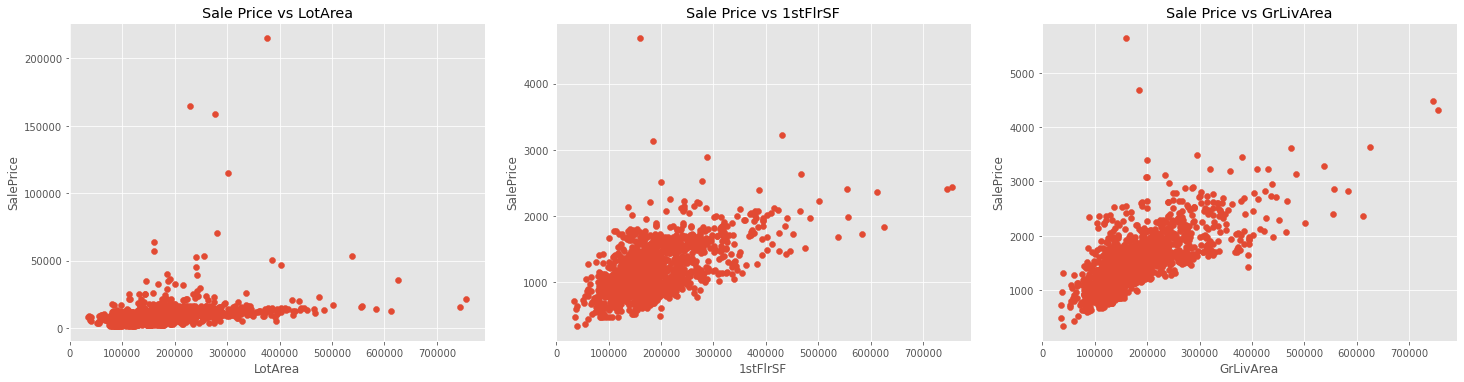

In [31]:
# Your code here
fig, axes = plt.subplots(1, 3, figsize=(20,5))
plt.tight_layout(w_pad=4)

for i, col in enumerate(features.columns):
    axes[i].scatter(target, features[col])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('SalePrice')
    axes[i].set_title('Sale Price vs {}'.format(col))
  

## Create evaluation metrics

- Import `r2_score` and `mean_squared_error` from `sklearn.metrics` 
- Create a function `performance(true, predicted)` to calculate and return both the R-squared score and Root Mean Squared Error (RMSE) for two equal-sized arrays for the given true and predicted values 
    - Depending on your version of sklearn, in order to get the RMSE score you will need to either set `squared=False` or you will need to take the square root of the output of the `mean_squared_error` function - check out [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) or this helpful and related [StackOverflow post](https://stackoverflow.com/questions/17197492/is-there-a-library-function-for-root-mean-square-error-rmse-in-python)
    - The benefit of calculating RMSE instead of the Mean Squared Error (MSE) is that RMSE is in the same units at the target - here, this means that RMSE will be in dollars, calculating how far off in dollars our predictions are away from the actual prices for homes, on average

In [33]:
# Import metrics
from sklearn.metrics import r2_score, mean_squared_error

# Define the function
def performance(y_true, y_predict):
    """ 
    Calculates and returns the two performance scores between 
    true and predicted values - first R-Squared, then RMSE
    """

    # Calculate the r2 score between 'y_true' and 'y_predict'
    r2 = r2_score(y_true, y_predict)

    # Calculate the root mean squared error between 'y_true' and 'y_predict'
    rmse = np.sqrt(mean_squared_error(y_true, y_predict))

    # Return the score

    return r2, rmse


# Test the function
score = performance([3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3])
score

# [0.9228556485355649, 0.6870225614927066]

(0.9228556485355649, 0.6870225614927066)

## Split the data into training and test sets

- Split `features` and `target` datasets into training/test data (80/20) 
- For reproducibility, use `random_state=42`

In [38]:
from sklearn.model_selection import train_test_split 

# Split the data into training and test subsets
X_train, _test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

## Grow a vanilla regression tree

- Import the `DecisionTreeRegressor` class
- Run a baseline model for later comparison using the datasets created above
- Generate predictions for test dataset and calculate the performance measures using the function created above 
- Use `random_state=45` for tree instance
- Record your observations

In [41]:
# Import DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

# Instantiate DecisionTreeRegressor 
# Set random_state=45
regressor = DecisionTreeRegressor(random_state=45)

# Fit the model to training data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)

# Calculate performance using the performance() function 
score = performance(y_test, y_pred)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

(0.5961521990414137, 55656.48543887347)

## Hyperparameter tuning (I)

- Find the best tree depth using depth range: 1-30
- Run the regressor repeatedly in a `for` loop for each depth value  
- Use `random_state=45` for reproducibility
- Calculate RMSE and r-squared for each run 
- Plot both performance measures for all runs 
- Comment on the output 

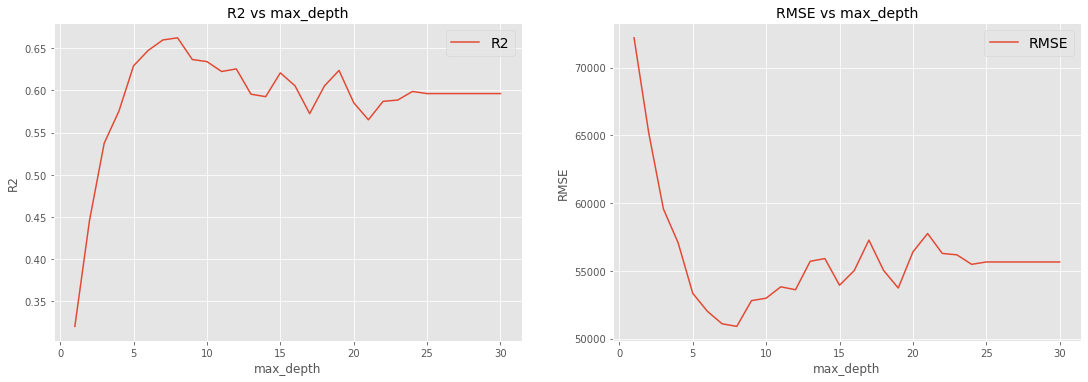

In [50]:
# Your code here 
range_ = np.linspace(1, 30, 30)
parameter = 'max_depth'

r2_list = []
rmse_list = []

for val in range_:
    reg = DecisionTreeRegressor(random_state=45, max_depth=int(val))
    reg.fit(X_train, y_train)
     
    y_pred = reg.predict(X_test)
    score = performance(y_test, y_pred)
    
    r2_list.append(score[0])
    rmse_list.append(score[1])
    
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plt.tight_layout(w_pad=6)

axes[0].plot(range_, r2_list, label='R2')
axes[0].set_xlabel(parameter)
axes[0].set_ylabel('R2')
axes[0].set_title(f'R2 vs {parameter}', fontsize=14)
axes[0].legend(fontsize=14)
#plt.xticks(np.arange(0, 35, step=1))

axes[1].plot(range_, rmse_list, label='RMSE')
axes[1].set_xlabel(parameter)
axes[1].set_ylabel('RMSE')
axes[1].set_title(f'RMSE vs {parameter}', fontsize=14)
axes[1].legend(fontsize=14)

In [ ]:
# The optimum max_depth = 8

## Hyperparameter tuning (II)

- Repeat the above process for `min_samples_split` 
- Use a range of values from 2-10 for this hyperparameter 
- Use `random_state=45` for reproducibility
- Visualize the output and comment on results as above 

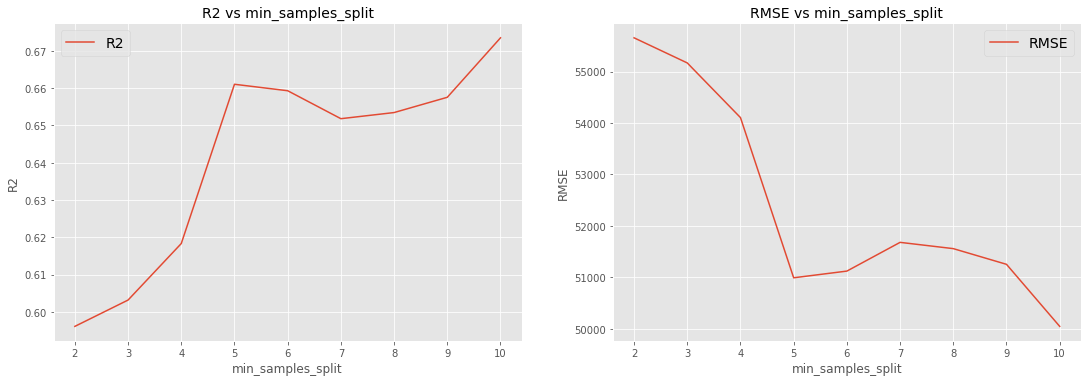

In [51]:
# Your code here 
range_ = np.linspace(2, 10, 9)
parameter = 'min_samples_split'

r2_list = []
rmse_list = []

for val in range_:
    reg = DecisionTreeRegressor(random_state=45, min_samples_split=int(val))
    reg.fit(X_train, y_train)
     
    y_pred = reg.predict(X_test)
    score = performance(y_test, y_pred)
    
    r2_list.append(score[0])
    rmse_list.append(score[1])
    
fig, axes = plt.subplots(1, 2, figsize=(15,5))
plt.tight_layout(w_pad=6)

axes[0].plot(range_, r2_list, label='R2')
axes[0].set_xlabel(parameter)
axes[0].set_ylabel('R2')
axes[0].set_title(f'R2 vs {parameter}', fontsize=14)
axes[0].legend(fontsize=14)
#plt.xticks(np.arange(0, 35, step=1))

axes[1].plot(range_, rmse_list, label='RMSE')
axes[1].set_xlabel(parameter)
axes[1].set_ylabel('RMSE')
axes[1].set_title(f'RMSE vs {parameter}', fontsize=14)
axes[1].legend(fontsize=14)

In [ ]:
# The optimum min_samples_split = 5

# Run the *optimized* model 

- Use the best values for `max_depth` and `min_samples_split` found in previous runs and run an optimized model with these values 
- Calculate the performance and comment on the output 

In [54]:
# Your code here 
# Import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=8, min_samples_split=5, random_state=45)
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

score = performance(y_test, y_pred)
score

# [0.5961521990414137, 55656.48543887347] - R2, RMSE

(0.6832674743742246, 49289.367940519915)

In [ ]:
# The optimed model improved the performancem compared to vanilla model

## Level up (Optional)

- How about bringing in some more features from the original dataset which may be good predictors?
- Also, try tuning more hyperparameters like `max_features` to find a more optimal version of the model 

In [ ]:
# Your code here 

## Summary 

In this lab, we looked at applying a decision-tree-based regression analysis on the Ames Housing dataset. We saw how to train various models to find the optimal values for hyperparameters. 